In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import colorcet as cc
import cartopy
import cartopy.crs as ccrs
import csv
import copy as cp
import random as rand
import random as ra
from scipy.stats import pearsonr, linregress
from scipy.signal import detrend
from scipy.io import loadmat
from matplotlib import cm, colors
from numba import njit, vectorize
#%matplotlib notebook

In [2]:
#The interval of time we're looking at (1980 to 2019)
startyear = 1980
endyear = 2010
timeseries = np.arange(startyear, endyear + 1, 1) #yearly
timeseries_cont = np.arange(startyear, endyear + 1, 1/12) #monthly

#dictionary of months
monthsnum = np.arange(1,13,1)
monthsind = np.arange(0,12,1)
monthsstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthsnam = ['J','F','M','A','M','J','J','A','S','O','N','D']
months = {1:'January',2:'February',3:'March',
          4:'April',5:'May',6:'June',7:'July',8:'August',
          9:'September',10:'October',11:'November',12:'December'}
names = ['NSIDC','Had2CIS','CANCM4','GEM_NEMO','COMBINED']
ensembles = np.arange(0,10,1)

#colours for graphing
col = ['#7f00ff','#6000ff','#3a06f9','#0300ff','#004aff','#007eff',
       '#009fff','#00c3ff','#00dcff','#00fffe','#00ffd3','#19e67b']

#regions
PanAntarctic = np.array([0,360])
Weddell = np.array([300,20])
Indian = np.array([20,90])
WestPacific = np.array([90,160])
Ross = np.array([160,230])
Amundsen = np.array([230,300])

In [3]:
#function to calculate sea ice extent from sea ice fraction/concentration

@njit
def calculate_SIE (SIC_array, latdat, londat, region):
    '''
    SIC_array: 2D array of SIC values in the form of [lat][lon]
    lat: 1D array of all latitudes
    lon: 1D array of all longitudes
    region: an array with the two bounding longitudes that define the sector (e.g. [-30, 60])
    '''
    
    #Will keep track of sea ice extent
    SIE_counter = 0

    #iterate over all latitudes and longitudes
    for i in range(len(latdat)): 
        for j in range(len(londat)):
            
            #only consider SOUTHERN hemisphere
            if latdat[i] < 0:
                
                #only consider a certain region
                if region[0] == Weddell[0]: #Weddell
                    if londat[j] >= region[0] or londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                            
                else: #all other regions
                    if londat[j] >= region[0] and londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15 and SIC <= 1.: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
    
    return SIE_counter/1e6



#function to write data to .txt file

def writedat(yearlydata, filename, loc = "Region_PanAntarcticSIE"):
    '''
    yearlydata: (dictionary) the data to be written to file, in the form of a dictionary
    filename: (string) the name of the file, excluding the .txt
    '''

    #First, create file
    #x is to create file
    #w is to rewrite file. If file doesn't exist, create file.
    #a is to append to file. If file doesn't exist, create file.
    #r is to read file

    f = open(loc + "/" + str(filename) + ".txt", "w")

    #go year by year
    for year in yearlydata.keys():

        f.write(str(year) + " ")

        #SIE month by month for the above year
        for val in yearlydata[year]:

            f.write(str(val) + " ")

        f.write("\n")

    f.close()
    
    
    
#function to retrieve data from .txt file

def retrievedat (filename, loc = "Region_PanAntarcticSIE", output_type = 'array'):
    '''
    retrieve dictionary data from a .txt file in a specific format
    '''
    
    #dictionary full of data to be returned
    datadict = {}
    
    f = open(loc + "/" + str(filename) + ".txt", "r")
    
    #go line by line
    for line in f:
        
        #split line into an array
        line.replace('\n', '')
        linearray = line.split()
        
        
        year = np.int64(linearray[0])
        dat = linearray[1:]
        
        if year >= startyear and year <= endyear:
            #convert nones to None and values to floats
            for i,d in enumerate(dat):
                if d == 'None':
                    dat[i] = np.nan
                else:
                    dat[i] = np.float64(d)

            datadict[year] = dat
    
    f.close()
    if output_type == 'array' or output_type == 'Array':
        return Dict1D(datadict)
    else:
        return datadict


#function to calculate average of array w/ None types

def average (array):
    
    net = 0
    count = 0
    
    for dat in array:
        if dat is not None and np.isnan(dat) == False:
            net += dat
            count += 1
            
    return net/count


#function to calculate average between CANCM4 and GEM_NEMO

def model_average (model1, model2, N=2):
    
    dictaveraged = {}
    
    for year in timeseries:
        
        dictaveraged[year]= [np.nan]*12
        
        for leadtime in monthsind:
            
            net = model1[year][leadtime] + model2[year][leadtime]
            ave = net/N #average
            
            dictaveraged[year][leadtime] = ave
    
    return dictaveraged


#function to retrieve all data pertaining to a specific month of the year

def DataForMonth (dataset, month, initmonth = 1):
    
    #Determine what type the input is in (e.g. array or dictionary)
    if type(dataset) == dict:
        dataset1D = Dict1D(dataset)
    else:
        dataset1D = dataset
            
    #Now pick out all the data corresponding to the specified month
    #e.g. if month = 1 and initmonth = 1, then it should pick out index 0, index 12, index 24, etc...
    
    index = (month - 1) - (initmonth - 1)
    datasetmonth = []

    if month < initmonth:
        index += 12
    while index < len(dataset1D):
        datasetmonth.append(dataset1D[index])
        index += 12 #jump forward 12 months
            
    return datasetmonth


#Put a dictionary of data into a 1D array

def Dict1D (dataset):
    
    #put all the data into a 1D array
    
    dataset1D = []
    for year in dataset.keys():
        for im in monthsind:
            dataset1D.append(dataset[year][im])
    
    return dataset1D


#Quickplot

def QuickPlot (datadict, colour = "Navy"):
    
    fig, axis = plt.subplots(1,1,figsize=(8,6))
    
    xaxis = timeseries_cont
    yaxis = Dict1D(datadict)
    
    axis.plot(xaxis, yaxis, color = colour)
    axis.grid()
    
    fig.tight_layout()
    
    
#Anomalize

def Anomalize (datadict, return_anomalies = False):

    #assumes datadict is sorted by initialization month
    #calculate the monthlymeans
    monthlymeans = [0 for _ in range(12)]
    for mi in monthsind: #go month by month

        net = 0
        count = 0
        for year in datadict.keys(): 
            if year >= 2000 and year <= 2020:
                net += datadict[year][mi]
                count += 1
        mean = net / count
        monthlymeans[mi] = mean

    if return_anomalies:
        return monthlymeans

    #create a dictionary of anomalies
    anomalydict = {}
    for year in datadict.keys():
        anomalydict[year] = list(np.array(datadict[year]) - np.array(monthlymeans))

    return anomalydict

def sortbylead (data):

    mlead0 = {} #starts in january 1980
    mlead1 = {} #starts in february 1980
    mlead2 = {} #starts in march 1980
    mlead3 = {} #etc...
    mlead4 = {}
    mlead5 = {}
    mlead6 = {}
    mlead7 = {}
    mlead8 = {}
    mlead9 = {}
    mlead10 = {}
    mlead11 = {}

    for year in data[0].keys():

        mlead0[year] = []
        mlead1[year] = []
        mlead2[year] = []
        mlead3[year] = []
        mlead4[year] = []
        mlead5[year] = []
        mlead6[year] = []
        mlead7[year] = []
        mlead8[year] = []
        mlead9[year] = []
        mlead10[year] = []
        mlead11[year] = []

        for mi in monthsind:

            mlead0[year].append(data[mi][year][0])
            mlead1[year].append(data[mi][year][1])
            mlead2[year].append(data[mi][year][2])
            mlead3[year].append(data[mi][year][3])
            mlead4[year].append(data[mi][year][4])
            mlead5[year].append(data[mi][year][5])
            mlead6[year].append(data[mi][year][6])
            mlead7[year].append(data[mi][year][7])
            mlead8[year].append(data[mi][year][8])
            mlead9[year].append(data[mi][year][9])
            mlead10[year].append(data[mi][year][10])
            mlead11[year].append(data[mi][year][11])

    return [mlead0,mlead1,mlead2,mlead3,mlead4,mlead5,mlead6,mlead7,mlead8,mlead9,mlead10,mlead11]

In [4]:
#COMPATIBLE WITH NUMBA

#function to calculate sea ice extent from sea ice fraction/concentration

@njit
def calculate_SIE (SIC_array, latdat, londat, region):
    '''
    SIC_array: 2D array of SIC values in the form of [lat][lon]
    lat: 1D array of all latitudes
    lon: 1D array of all longitudes
    region: an array with the two bounding longitudes that define the sector (e.g. [-30, 60])
    '''
    
    #Will keep track of sea ice extent
    SIE_counter = 0

    #iterate over all latitudes and longitudes
    for i in range(len(latdat)): 
        for j in range(len(londat)):
            
            #only consider SOUTHERN hemisphere
            if latdat[i] < 0:
                
                #only consider a certain region
                if region[0] > region[1]:
                    if londat[j] >= region[0] or londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                else:
                    if londat[j] >= region[0] and londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                            
    return SIE_counter/1e6


#function to calculate average of array, numba-compatible
@njit
def average (array):
    
    net = 0.
    count = 0
    
    for dat in array:
        if np.isnan(dat) == False:
            net = net + dat
            count = count + 1
            
    return net/count

#fit a linear regression line
@njit
def Linear_Regression (data):
    
    #Returns the slope (m) and y intercept (b) for a linear regression line.
    #Assumes input data are evenly spaced, and there is no missing data.
    N = len(data)
    xaxis = np.arange(0,N)
    yaxis = data
    x_mean = average(xaxis)
    y_mean = average(yaxis)
    
    net1 = 0; net2 = 0 #variables to keep track of sum
    for i in range(N):
        
        #data pts
        x_i = xaxis[i]; y_i = yaxis[i]
        
        #sums
        net1 += (x_i - x_mean)*(y_i - y_mean)
        net2 += (x_i - x_mean)**2
    
    #slope and intercept
    m = net1/net2
    b = y_mean - m*x_mean
        
    #return answer
    return [m,b]

#remove a linear trend from data
@njit
def Remove_Trend (data, use_mitch_method = True):
    '''
    Make sure input array is floats and not ints, or else output will be wrong.
    If using Mitch's method, each entry in the input data should correspond to a different year.
    
    Relies on custom functions:
    average, Linear_Regression
    '''
    if use_mitch_method == False: #regular detrending

        #copy input data
        data_new = np.copy(data)

        #if data set is small, just remove the mean
        if len(data_new) <= 3:

            data_new_mean = average(data_new)
            for i in range(len(data_new)):
                data_new[i] = data_new[i] - data_new_mean

        #else, calculate the linear trendline and remove it
        else:

            regression_params = Linear_Regression(data_new)
            slope = regression_params[0]; intercept = regression_params[1]
            print(slope,intercept)
            
            trendline = [slope*float(x) + intercept for x in range(len(data_new))]

            for i in range(len(data_new)):
                data_new[i] = data_new[i] - trendline[i]
        
        
    if use_mitch_method == True: #Mitch's detrending method
        
        #copy input data
        data_new = np.copy(data)
        
        for yrs in range(len(data)): #index variable running from 0 to len(data), used
                                     #for selecting the appropriate subset of years to apply Mitch's method to
        
            #copy input data again, but only select a subset
            data_new_subset = np.copy(data)[:yrs+1]

            #if data set is small, just remove the mean
            if len(data_new_subset) <= 3:

                data_new_mean = average(data_new_subset)
                for i in range(len(data_new_subset)):
                    data_new_subset[i] = data_new_subset[i] - data_new_mean

            #else, calculate the linear trendline and remove it
            else:

                regression_params = Linear_Regression(data_new_subset)
                slope = regression_params[0]; intercept = regression_params[1]

                trendline = [slope*float(x) + intercept for x in range(len(data_new_subset))]

                for i in range(len(data_new_subset)):
                    data_new_subset[i] = data_new_subset[i] - trendline[i]
            
            #put into array
            data_new[yrs] = data_new_subset[yrs]    
        
    return data_new


#Calculate anomaly correlation coefficient
@njit
def ACC (observation, prediction, month, initmonth, detrend = False, already_sorted = False):

    '''
    #specify initialization month of modelled data
    #choose month to be analyzed
    #month and initmonth range from 1 to 12, and are integers
    #observation and prediction input can be arrays or dictionaries
    
    IF USING PRE-SORTED AND TM < IM, MAKE SURE TO ACCOUNT FOR YEARS NOT LINING UP!!!
    e.g.,
    if month < initmonth:
        o_array = np.delete(o_array, 0)
        p_array = np.delete(p_array, -1)
    
    Relies on custom functions:
    DataForMonth, average, Remove_Trend
    '''

    if already_sorted == False:
        #acquire data for the specified month, across all years
        o_array = DataForMonth(observation, month, 1)
        p_array = DataForMonth(prediction, month, initmonth)

        #if month < initmonth, need to account for the fact that the YEARS of the observational and
        #prediction data sets don't line up
        if month < initmonth:
            o_array = np.delete(o_array, 0)
            p_array = np.delete(p_array, -1)

    else:
        o_array = observation
        p_array = prediction
    
    #detrend if desired
    if detrend == True:
        o_array = Remove_Trend(np.asarray(o_array))
        p_array = Remove_Trend(np.asarray(p_array))

    return np.corrcoef(o_array,p_array)[0,1]

@njit
def ACC_matrix (observations, predictions_all, detrend=False):
    '''
    Input observations must be a 1D array
    Input "predictions_all" must be an array of 1D arrays:
    [(initmonth = Jan) array, (initmonth = Feb) array, etc.]
    Observations are simply a 1D array, or a dictionary
    
    Depends on custom functions:
    ACC
    '''
    
    #set up ACC matrix
    #columns are target month
    #rows are leadtime
    skill_matrix = np.full((12,12),np.nan)
    
    #populate ACC matrix
    for tm in monthsnum: 
        for lead in monthsind:
            
            #calculate corresponding initialization month
            im = tm - lead
            if im < 1:
                im = im + 12
            
            #acquire predictions for this leadtime
            predictions = predictions_all[im-1]
            
            #calculate the ACC
            skill = ACC(observations, predictions, tm, im, detrend=detrend)
            
            #Put in skill matrix
            skill_matrix[lead][tm-1] = skill
    
    return skill_matrix

In [5]:
#let's do target month of january, lead 0
#    CanCM4dict_mlead[e][lead]

#define a function to get SIE anomaly time series as a function of model, ensemble number, lead time, target month

def getSIEsequence (model,ens,tm,lead):
    
    #get initialization month from tm and lead
    im = tm - lead
    if im < 1:
        im += 12
    im_str = monthsstr[im-1]
    e_str = str(ens)
    
    #CanCM4i
    if model == 'CanCM4i' or model == 'CanCM4':
        CanCM4i_data_all = retrievedat('CANCM4datE' + e_str + im_str)
        CanCM4i_data_month = DataForMonth(CanCM4i_data_all,tm,initmonth=im)
        return CanCM4i_data_month
    
    #GEM-NEMO
    if model == 'GEMNEMO' or model == 'GEM-NEMO' or model == 'GEM_NEMO':
        GEMNEMOi_data_all = retrievedat('GEMNEMOdatE' + e_str + im_str)
        GEMNEMOi_data_month = DataForMonth(GEMNEMOi_data_all,tm,initmonth=im)
        return GEMNEMOi_data_month
    
    else:
        print("ERROR: invalid model specified for function getSIEsequence")

In [6]:
# matrix of ensemble standard deviations, as a function of target month (first index) and lead time (second index)
var_matrix_CanCM4i = np.full((12,12),np.nan)
var_matrix_GEMNEMO = np.full((12,12),np.nan)

#populate the CanCM4i matrix
print('Working on CanCM4i...')
for tm in monthsnum:
    for lead in monthsind:
        
        #get the data and organize it
        ensemble_data = []
        for e in range(10):
            SIEsequence = np.array(getSIEsequence('CanCM4',e,tm,lead))
            ensemble_data.append(SIEsequence)
        
        #calculate standard deviations
        ensemble_data_T = np.transpose(ensemble_data)
        var_list = []
        for row in ensemble_data_T:
            var = np.var(row,ddof=1) #/ np.sqrt(len(row))
            var_list.append(var)
        
        #average var and put into appropriate matrix
        var_ave = np.average(var_list)
        var_matrix_CanCM4i[tm-1][lead] = var_ave
        
#populate the GEM-NEMO matrix
print('Working on GEM-NEMO...')
for tm in monthsnum:
    for lead in monthsind:
        
        #get the data and organize it
        ensemble_data = []
        for e in range(10):
            SIEsequence = np.array(getSIEsequence('GEMNEMO',e,tm,lead))
            ensemble_data.append(SIEsequence)
        
        #calculate standard deviations
        ensemble_data_T = np.transpose(ensemble_data)
        var_list = []
        for row in ensemble_data_T:
            var = np.var(row,ddof=1) #/ np.sqrt(len(row))
            var_list.append(var)
        
        #average var and put into appropriate matrix
        var_ave = np.average(var_list)
        var_matrix_GEMNEMO[tm-1][lead] = var_ave
        
std_matrix_CanCM4i = np.sqrt(var_matrix_CanCM4i)
std_matrix_GEMNEMO = np.sqrt(var_matrix_GEMNEMO)

print("Done.")

Working on CanCM4i...
Working on GEM-NEMO...
Done.


In [7]:
#The interval of time we're looking at (1980 to 2019)
startyear = 1980
endyear = 2019
timeseries = np.arange(startyear, endyear + 1, 1) #yearly
timeseries_cont = np.arange(startyear, endyear + 1, 1/12) #monthly

In [8]:
# matrix of ensemble standard deviations, as a function of target month (first index) and lead time (second index)
var_matrix_CanCM4i_2019 = np.full((12,12),np.nan)
var_matrix_GEMNEMO_2019 = np.full((12,12),np.nan)

#populate the CanCM4i matrix
print('Working on CanCM4i...')
for tm in monthsnum:
    for lead in monthsind:
        
        #get the data and organize it
        ensemble_data = []
        for e in range(10):
            SIEsequence = np.array(getSIEsequence('CanCM4',e,tm,lead))
            ensemble_data.append(SIEsequence)
        
        #calculate standard deviations
        ensemble_data_T = np.transpose(ensemble_data)
        var_list = []
        for row in ensemble_data_T:
            var = np.var(row,ddof=1) #/ np.sqrt(len(row))
            var_list.append(var)
        
        #average var and put into appropriate matrix
        var_ave = np.average(var_list)
        var_matrix_CanCM4i_2019[tm-1][lead] = var_ave
        
#populate the GEM-NEMO matrix
print('Working on GEM-NEMO...')
for tm in monthsnum:
    for lead in monthsind:
        
        #get the data and organize it
        ensemble_data = []
        for e in range(10):
            SIEsequence = np.array(getSIEsequence('GEMNEMO',e,tm,lead))
            ensemble_data.append(SIEsequence)
        
        #calculate standard deviations
        ensemble_data_T = np.transpose(ensemble_data)
        var_list = []
        for row in ensemble_data_T:
            var = np.var(row,ddof=1) #/ np.sqrt(len(row))
            var_list.append(var)
        
        #average var and put into appropriate matrix
        var_ave = np.average(var_list)
        var_matrix_GEMNEMO_2019[tm-1][lead] = var_ave

std_matrix_CanCM4i_2019 = np.sqrt(var_matrix_CanCM4i_2019)
std_matrix_GEMNEMO_2019 = np.sqrt(var_matrix_GEMNEMO_2019)

print("Done.")

Working on CanCM4i...
Working on GEM-NEMO...
Done.


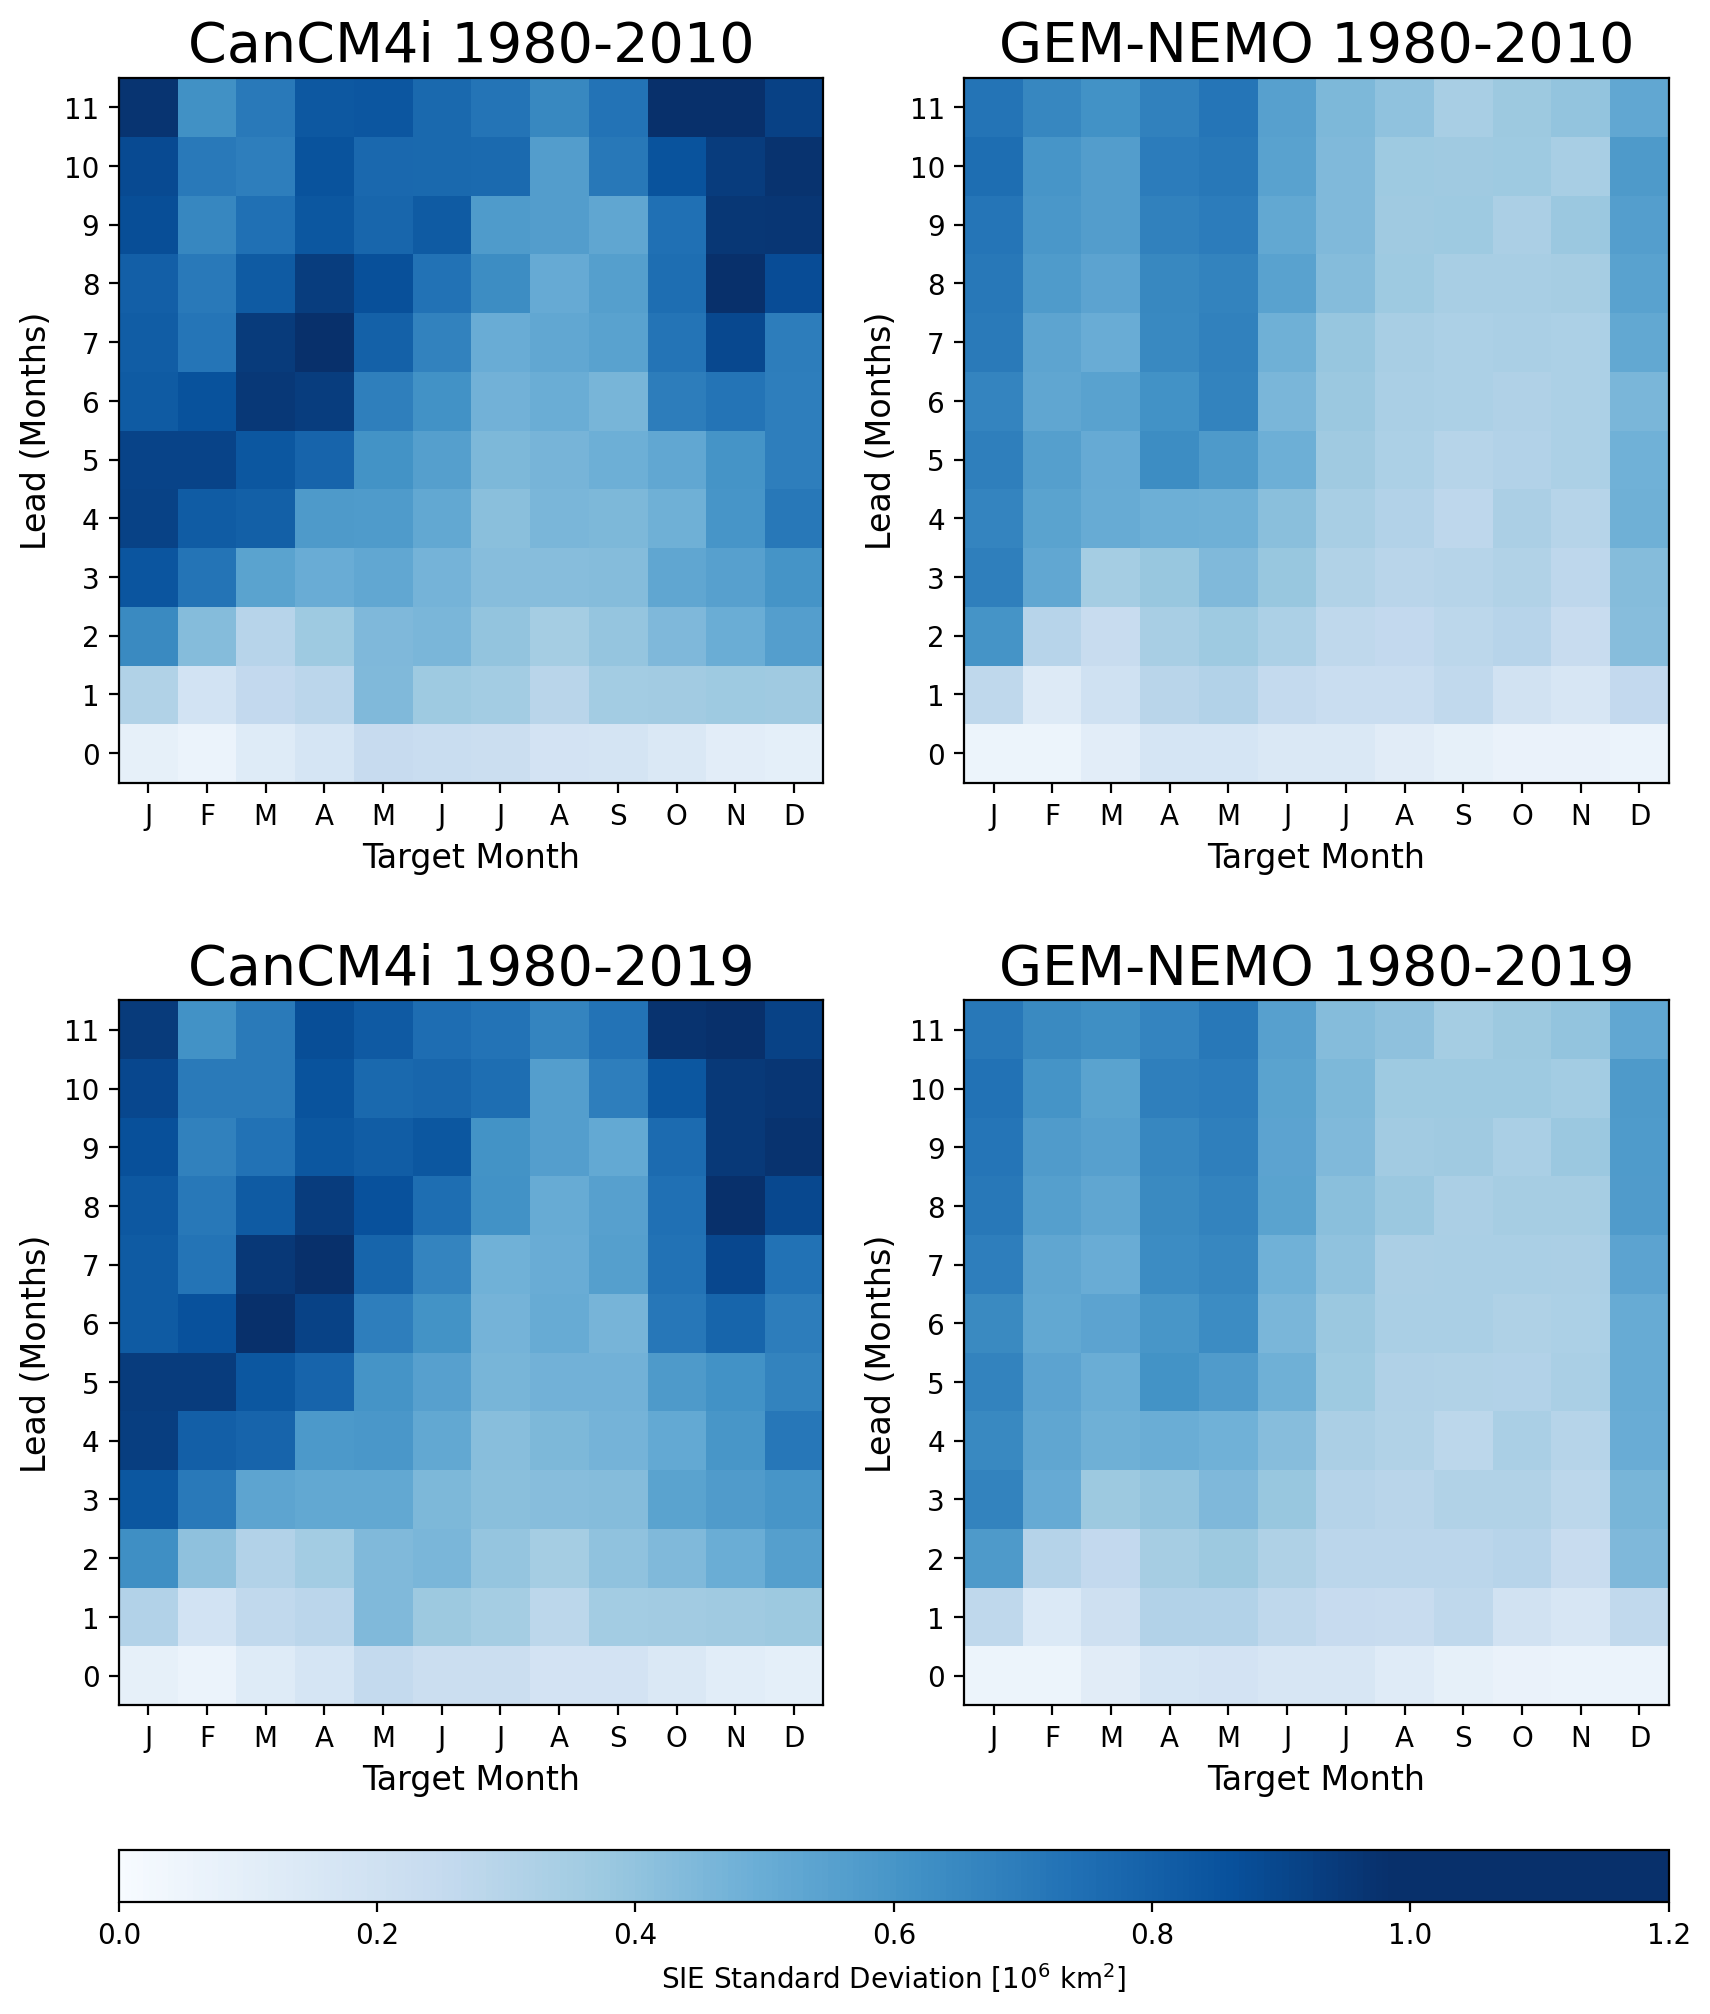

In [9]:
#configure color stuff
cmap = 'Blues'
N = 250
bounds = np.linspace(0,1.2,N)
norm = colors.BoundaryNorm(bounds, 1.25*N)

#plot
fig,axis = plt.subplots(2,2, figsize=(10,16), facecolor='white',dpi=200)

image0=axis[0][0].imshow(np.transpose(std_matrix_CanCM4i), cmap=cmap, norm=norm)
axis[0][0].set_xticks(np.arange(0,12,1))
axis[0][0].set_yticks(np.arange(0,12,1))
axis[0][0].set_xticklabels(monthsnam, rotation=0)
axis[0][0].set_xlabel("Target Month",size=12)
axis[0][0].set_ylabel("Lead (Months)",size=12)
axis[0][0].invert_yaxis()
axis[0][0].set_title("CanCM4i 1980-2010",size=20)

image1=axis[0][1].imshow(np.transpose(std_matrix_GEMNEMO), cmap=cmap, norm=norm)
axis[0][1].set_xticks(np.arange(0,12,1))
axis[0][1].set_yticks(np.arange(0,12,1))
axis[0][1].set_xticklabels(monthsnam, rotation=0)
axis[0][1].set_xlabel("Target Month",size=12)
axis[0][1].set_ylabel("Lead (Months)",size=12)
axis[0][1].invert_yaxis()
axis[0][1].set_title("GEM-NEMO 1980-2010",size=20)

image2=axis[1][0].imshow(np.transpose(std_matrix_CanCM4i_2019), cmap=cmap, norm=norm)
axis[1][0].set_xticks(np.arange(0,12,1))
axis[1][0].set_yticks(np.arange(0,12,1))
axis[1][0].set_xticklabels(monthsnam, rotation=0)
axis[1][0].set_xlabel("Target Month",size=12)
axis[1][0].set_ylabel("Lead (Months)",size=12)
axis[1][0].invert_yaxis()
axis[1][0].set_title("CanCM4i 1980-2019",size=20)

image3=axis[1][1].imshow(np.transpose(std_matrix_GEMNEMO_2019), cmap=cmap, norm=norm)
axis[1][1].set_xticks(np.arange(0,12,1))
axis[1][1].set_yticks(np.arange(0,12,1))
axis[1][1].set_xticklabels(monthsnam, rotation=0)
axis[1][1].set_xlabel("Target Month",size=12)
axis[1][1].set_ylabel("Lead (Months)",size=12)
axis[1][1].invert_yaxis()
axis[1][1].set_title("GEM-NEMO 1980-2019",size=20)


cticks = np.arange(0,1.4,0.2)
sfactor = 1
fig.colorbar(image0, ax=[axis[0][0],axis[0][1], axis[1][0], axis[1][1]], shrink=sfactor, ticks=cticks, anchor=(0,1.7),orientation=1, aspect=30,label='SIE Standard Deviation [10$^6$ km$^2$]')
plt.show()